In [1]:
import pandas as pd
from pathlib import Path

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the data
train_df =  pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/train.csv', nrows = 10_000_000)
test_df =  pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv')


2025-08-18 15:21:01.181388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755530461.193175       8 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755530461.197077       8 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-18 15:21:01.211569: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
train_df.head()


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
test_df.head()


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-10-01 21:26:11.0000001,2010-10-01 21:26:11 UTC,-73.983130,40.761970,-73.994386,40.749236,1
1,2013-10-06 01:38:00.00000083,2013-10-06 01:38:00 UTC,-73.948505,40.753977,-73.808195,40.731952,2
2,2012-03-30 19:13:53.0000001,2012-03-30 19:13:53 UTC,-73.973964,40.791979,-73.979018,40.785544,1
3,2012-02-08 02:57:23.0000001,2012-02-08 02:57:23 UTC,-73.991478,40.738907,-73.907198,40.861572,2
4,2013-12-13 22:56:00.000000237,2013-12-13 22:56:00 UTC,-73.986281,40.740067,-73.933927,40.856781,2


In [5]:
# check datatypes
train_df.dtypes


key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [6]:
train_df.describe()


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.000000e+07,1.000000e+07,1.000000e+07,9.999931e+06,9.999931e+06,1.000000e+07
mean,1.133854e+01,-7.250775e+01,3.991934e+01,-7.250897e+01,3.991913e+01,1.684793e+00
std,9.799930e+00,1.299421e+01,9.322539e+00,1.287532e+01,9.237280e+00,1.323423e+00
min,-1.077500e+02,-3.439245e+03,-3.492264e+03,-3.426601e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076712e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,1.273310e+03,3.457626e+03,3.344459e+03,3.457622e+03,3.351403e+03,2.080000e+02


In [7]:
num_rows = len(train_df)
train_df = train_df[(train_df['fare_amount'] > 0)]
print(f'Drop {num_rows - len(train_df)} rows')


Drop 689 rows


In [8]:
def change_outliers_by_range(df, column_name, min_range, max_range):
    before_len = df.shape[0]
    mask = (df[column_name].between(min_range,max_range))
    selected_rows = df[mask]
    changed_rows = before_len - selected_rows.shape[0]
    
    dtype_of_column = df[column_name].dtype
    mean_of_column = selected_rows[column_name].mean()
    if dtype_of_column == np.int64:
        mean_of_column = round(mean_of_column)
    
    df.loc[~mask, column_name] = mean_of_column
    return changed_rows
    

def change_outliers(df):
    print("Change", change_outliers_by_range(df, 'pickup_latitude', 40.5, 41.0), "rows by pickup lat")
    print("Change", change_outliers_by_range(df, 'dropoff_latitude', 40.5, 41.0), "rows by dropoff lat")
    print("Change", change_outliers_by_range(df, 'pickup_longitude', -74.3, -73.6), "rows by pickup long")
    print("Change", change_outliers_by_range(df, 'dropoff_longitude', -74.3, -73.6), "rows by dropoff long")
    print("Change", change_outliers_by_range(df, 'passenger_count', 1, 8), "rows by passenger cnt")
    

print("Training data outliers: ")
change_outliers(train_df)
print("\nTest data outliers: ")
change_outliers(test_df)


Training data outliers: 
Change 203278 rows by pickup lat
Change 202913 rows by dropoff lat
Change 204324 rows by pickup long
Change 203603 rows by dropoff long
Change 35344 rows by passenger cnt

Test data outliers: 
Change 213 rows by pickup lat
Change 213 rows by dropoff lat
Change 216 rows by pickup long
Change 219 rows by dropoff long
Change 45 rows by passenger cnt


In [9]:
train_df.describe()


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9.999311e+06,9.999311e+06,9.999311e+06,9.999311e+06,9.999311e+06,9.999311e+06
mean,1.133971e+01,-7.397545e+01,4.075083e+01,-7.397456e+01,4.075123e+01,1.691651e+00
std,9.798693e+00,3.442777e-02,2.676912e-02,3.395817e-02,3.057308e-02,1.304345e+00
min,1.000000e-02,-7.430000e+01,4.050004e+01,-7.429990e+01,4.050003e+01,1.000000e+00
25%,6.000000e+00,-7.399206e+01,4.073700e+01,-7.399138e+01,4.073622e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075260e+01,-7.398014e+01,4.075312e+01,1.000000e+00
75%,1.250000e+01,-7.396876e+01,4.076708e+01,-7.396595e+01,4.076807e+01,2.000000e+00
max,1.273310e+03,-7.360093e+01,4.099974e+01,-7.360006e+01,4.099995e+01,7.000000e+00


In [10]:
train_df.isnull().sum()


key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [11]:
# Data preprocessing
def preprocess_data(df):
    airport_lat_long = (40.644600, -73.779700)
    la_guardia_airport_lat_long = (40.7733, -73.8718)
    near_airport = (((df["pickup_latitude"]  airport_lat_long[0] + 0.005) & 
                (df["pickup_latitude"] >= airport_lat_long[0] - 0.005) & 
                (df["pickup_longitude"]  airport_lat_long[1] + 0.005) & 
                (df["pickup_longitude"] >= airport_lat_long[1] - 0.005)) |
                
                ((df["pickup_latitude"]  la_guardia_airport_lat_long[0] + 0.002) & 
                (df["pickup_latitude"] >= la_guardia_airport_lat_long[0] - 0.003) & 
                (df["pickup_longitude"]  la_guardia_airport_lat_long[1] + 0.005) & 
                (df["pickup_longitude"] >= la_guardia_airport_lat_long[1] - 0.005))).astype(int)

    df['near_airport'] = near_airport
    
    df['manhattan_distance'] = (abs(df['pickup_longitude'] - df['dropoff_longitude']) +
                                 abs(df['pickup_latitude'] - df['dropoff_latitude']))
    
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['pickup_year'] = df['pickup_datetime'].dt.year
    df['pickup_month'] = df['pickup_datetime'].dt.month
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day'] = df['pickup_datetime'].dt.dayofweek
    is_weekend = ((df["pickup_day"] >=5) & 
                    (df["pickup_day"] 6)).astype(int)
    df['is_weekend'] = is_weekend
    
    is_holiday = (
        ((df['pickup_month'] == 12) & (df['pickup_datetime'].dt.day == 25)) |  
        ((df['pickup_month'] == 12) & (df['pickup_datetime'].dt.day == 26)) | 
        ((df['pickup_month'] == 12) & (df['pickup_datetime'].dt.day == 31)) |  
        ((df['pickup_month'] == 1) & (df['pickup_datetime'].dt.day == 1)) | 
        ((df['pickup_month'] == 7) & (df['pickup_datetime'].dt.day == 4))
    ).astype(int)

    df['is_holiday'] = is_holiday
    

preprocess_data(train_df)
preprocess_data(test_df)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (475585909.py, line 5)

In [12]:
train_df.head()


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [13]:
train_df["near_airport"].sum()


KeyError: 'near_airport'

In [14]:
train_df["is_holiday"].sum()


KeyError: 'is_holiday'

In [15]:
train_df["is_weekend"].sum()


KeyError: 'is_weekend'

In [16]:
grouped = train_df.groupby('pickup_hour')['fare_amount'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(grouped['pickup_hour'], grouped['fare_amount'])
plt.title('Average Fare Amount by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Fare Amount')
plt.xticks(grouped['pickup_hour'])
plt.show()


KeyError: 'pickup_hour'

In [17]:
grouped = train_df.groupby('near_airport')['fare_amount'].mean().reset_index()

plt.figure(figsize=(2, 5))
plt.bar(grouped['near_airport'], grouped['fare_amount'])
plt.title('Average Fare Amount by Near Airport')
plt.xlabel('Is Near of Airport')
plt.ylabel('Average Fare Amount')
plt.xticks(grouped['near_airport'])
plt.show()


KeyError: 'near_airport'

In [18]:
grouped = train_df.groupby('pickup_year')['fare_amount'].mean().reset_index()

plt.figure(figsize=(6, 6))
plt.bar(grouped['pickup_year'], grouped['fare_amount'])
plt.title('Average Fare Amount by Year')
plt.xlabel('Year')
plt.ylabel('Average Fare Amount')
plt.xticks(grouped['pickup_year'])
plt.show()


KeyError: 'pickup_year'

In [19]:
grouped = train_df.groupby('pickup_month')['fare_amount'].mean().reset_index()

plt.figure(figsize=(6, 6))
plt.bar(grouped['pickup_month'], grouped['fare_amount'])
plt.title('Average Fare Amount by Month')
plt.xlabel('Month')
plt.ylabel('Average Fare Amount')
plt.xticks(grouped['pickup_month'])
plt.show()


KeyError: 'pickup_month'

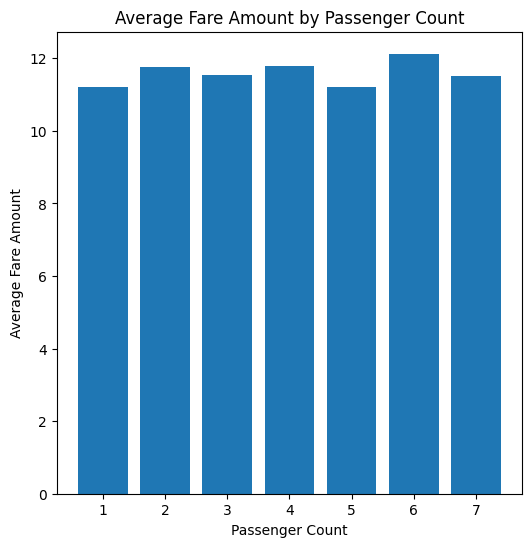

In [20]:
grouped = train_df.groupby('passenger_count')['fare_amount'].mean().reset_index()

plt.figure(figsize=(6, 6))
plt.bar(grouped['passenger_count'], grouped['fare_amount'])
plt.title('Average Fare Amount by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Average Fare Amount')
plt.xticks(grouped['passenger_count'])
plt.show()


In [21]:
grouped = train_df.groupby('pickup_day')['fare_amount'].mean().reset_index()

plt.figure(figsize=(5, 4))
plt.bar(grouped['pickup_day'], grouped['fare_amount'])
plt.title('Average Fare Amount by Day')
plt.xlabel('Day')
plt.ylabel('Average Fare Amount')
plt.xticks(grouped['pickup_day'])
plt.show()


KeyError: 'pickup_day'

In [22]:
grouped = train_df.groupby('is_holiday')['fare_amount'].mean().reset_index()

plt.figure(figsize=(2, 4))
plt.bar(grouped['is_holiday'], grouped['fare_amount'])
plt.title('Average Fare Amount by Holiday')
plt.xlabel('Is Holiday')
plt.ylabel('Average Fare Amount')
plt.xticks(grouped['is_holiday'])
plt.show()


KeyError: 'is_holiday'

In [23]:
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'near_airport', 'manhattan_distance', 'pickup_year', 'pickup_month', 'pickup_hour', 'passenger_count']
X = train_df[features].values
y = train_df['fare_amount'].values


KeyError: "['near_airport', 'manhattan_distance', 'pickup_year', 'pickup_month', 'pickup_hour'] not in index"

In [24]:
X_test = test_df[features].values


KeyError: "['near_airport', 'manhattan_distance', 'pickup_year', 'pickup_month', 'pickup_hour'] not in index"

In [25]:
# Feature scaling
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# X_test = scaler.transform(X_test)


In [26]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69)


NameError: name 'X' is not defined

In [27]:
print(X.shape)
print(y.shape)

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)


NameError: name 'X' is not defined

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


NameError: name 'X_train' is not defined

In [29]:
# Evaluate on validation set
validation_predictions_lr = lr_model.predict(X_val)
validation_rmse_lr = np.sqrt(mean_squared_error(y_val, validation_predictions_lr))
print("Validation RMSE (Linear Regression):", validation_rmse_lr)

# Evaluate on full training set
train_predictions_lr = lr_model.predict(X)
train_rmse_lr = np.sqrt(mean_squared_error(y, train_predictions_lr))
print("Training RMSE (Linear Regression):", train_rmse_lr)


NameError: name 'X_val' is not defined

In [30]:
# Make predictions on the test set
test_predictions_lr = lr_model.predict(X_test)

# Save predictions to a CSV file
submission_df_lr =  pd.DataFrame(
    {'key': test_df.key, 'fare_amount': test_predictions_lr},
    columns = ['key', 'fare_amount'])
submission_df_lr.to_csv('lr_submission.csv', index=False)


NameError: name 'X_test' is not defined

In [31]:
import xgboost as xgb

# Define XGBoost model parameters
xgb_params = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'rmse',  # Evaluation metric (Root Mean Squared Error)
    'max_depth': 20,  # Maximum depth of the decision trees
    'subsample': 0.85,  # Subsample ratio of the training instances
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'eta': 0.04,  # Learning rate
    'min_child_weight': 3,  # Minimum sum of instance weight needed in a child
    'gamma': 0.1,  # Minimum loss reduction required to make a further partition
    'seed': 42,  # Random seed for reproducibility
    'tree_method': 'hist',  # Use the histogram-based algorithm for better performance
    'nthread': -1,  # Use all available CPU cores
}

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val)
dtest = xgb.DMatrix(X_test)
dallTrain = xgb.DMatrix(X)

# Train XGBoost model
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=80)


NameError: name 'X_train' is not defined

In [32]:
# Evaluate on validation set
validation_predictions_xgb = xgb_model.predict(dval)
validation_rmse_xgb = np.sqrt(mean_squared_error(y_val, validation_predictions_xgb))
print("Validation RMSE (XGBoost):", validation_rmse_xgb)

# Train on validation set
train_predictions_xgb = xgb_model.predict(dallTrain)
train_rmse_xgb = np.sqrt(mean_squared_error(y, train_predictions_xgb))
print("Train RMSE (XGBoost):", train_rmse_xgb)


NameError: name 'xgb_model' is not defined

In [33]:
# # Define the model
# model = Sequential([
#     Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
#     Dropout(0.2),
#     Dense(64, activation='relu'),
#     Dropout(0.2),
#     Dense(1, activation='linear')
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val))


In [34]:
# # Evaluate the model
# val_predictions = model.predict(X_val)
# val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
# print("Validation RMSE: (Neural Network)", val_rmse)

# # Evaluate the model
# train_predictions = model.predict(X)
# train_rmse = np.sqrt(mean_squared_error(y, train_predictions))
# print("Train RMSE: (Neural Network)", train_rmse)


In [35]:
# Make predictions on the test set
test_predictions_xgb = xgb_model.predict(dtest)

# Save predictions to a CSV file
submission_df_xgb =  pd.DataFrame(
    {'key': test_df.key, 'fare_amount': test_predictions_xgb},
    columns = ['key', 'fare_amount'])
submission_df_xgb.to_csv('submission.csv', index=False)


NameError: name 'xgb_model' is not defined